In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='talk', style='ticks', color_codes=True)

from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas()

%matplotlib inline

In [2]:
bde = pd.read_csv('rdf_data_190531.csv.gz', index_col=0)
# bde_large = pd.read_csv('rdf_large_190409.csv.gz', index_col=0)

In [3]:
bde.shape

(484907, 7)

In [4]:
bde.drop_duplicates(subset=['molecule', 'fragment1', 'fragment2']).shape

(290664, 7)

In [5]:
# Get bond types corresponding to BDE measurements
bde_bond_types = bde.bond_type.value_counts()
bde_bond_types

C-H    321949
C-C     71166
H-N     27314
C-N     24707
C-O     24354
H-O     11884
N-O      1634
N-N      1597
O-O       302
Name: bond_type, dtype: int64

In [6]:
bde.head()

,molecule,bond_index,fragment1,fragment2,bde,bond_type,delta_stereo
rid,,,,,,,
1,NCCCC(=O)O,0,[CH2]CCC(=O)O,[NH2],87.599001,C-N,0
2,NCCCC(=O)O,1,[CH2]CC(=O)O,[CH2]N,82.344241,C-C,0
3,NCCCC(=O)O,2,[CH2]C(=O)O,[CH2]CN,86.313863,C-C,0
4,NCCCC(=O)O,3,O=[C]O,[CH2]CCN,95.898435,C-C,0
5,NCCCC(=O)O,5,NCCC[C]=O,[OH],111.408575,C-O,0


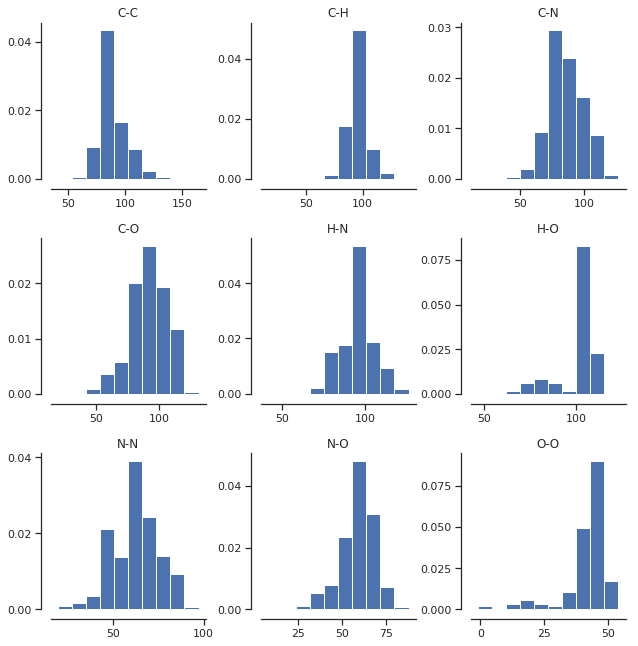

In [7]:
with sns.plotting_context('notebook'):
    fig, axmatrix = plt.subplots(nrows=3, ncols=3, figsize=(9, 9), sharey=False, sharex=False)

    for (btype, df), ax in zip(bde.groupby('bond_type'), axmatrix.flatten()):
        ax.hist(df['bde'], density=True)
        ax.set_title(btype)

    plt.tight_layout(h_pad=2)
    sns.despine(offset=10)

In [8]:
len(bde.molecule.unique())

42577

In [9]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(bde.molecule.unique(), test_size=1000, random_state=1)
train, valid = train_test_split(train, test_size=1000, random_state=1)

In [10]:
from nfp.preprocessing import SmilesPreprocessor, GraphSequence
from nfp.preprocessing import features
from nfp.preprocessing import get_ring_size

from preprocessor_utils import (
    SmilesBondIndexPreprocessor, ConcatGraphSequence, atom_featurizer, bond_features)

Using TensorFlow backend.


In [11]:
preprocessor = SmilesBondIndexPreprocessor(
    explicit_hs=True,
    atom_features=atom_featurizer,
    bond_features=bond_features)

inputs_train = preprocessor.fit(train)
inputs_valid = preprocessor.predict(valid)
# inputs_test = preprocessor.predict(test)

100%|██████████| 1000/1000 [00:00<00:00, 2624.72it/s]


In [12]:
preprocessor.atom_classes

99

In [13]:
preprocessor.bond_classes

104

In [14]:
def get_df(iinput, smiles, i):
    idf = pd.DataFrame(iinput['bond_indices'], columns=['bond_index'])
    idf['preprocessor_class'] = iinput['bond']
    idf['molecule'] = smiles
    idf['mol_index'] = i
    return idf

y_train_df = pd.concat([
    get_df(iinput, smiles, i) for i, (iinput, smiles)
    in enumerate(zip(tqdm_notebook(inputs_train), train))])

y_valid_df = pd.concat([
    get_df(iinput, smiles, i) for i, (iinput, smiles)
    in enumerate(zip(tqdm_notebook(inputs_valid), valid))])

In [15]:
y_train_df.shape

(1604572, 4)

In [17]:
y_train_df = y_train_df.merge(bde, how='left', left_on=['bond_index', 'molecule'],
                              right_on=['bond_index', 'molecule'])
y_valid_df = y_valid_df.merge(bde, how='left', left_on=['bond_index', 'molecule'],
                              right_on=['bond_index', 'molecule'])

In [18]:
y_train_df.head()

,bond_index,preprocessor_class,molecule,mol_index,fragment1,fragment2,bde,bond_type,delta_stereo
0,0,2,CC[C@H](C)CON,0,[CH2][C@H](C)CON,[CH3],89.000229,C-C,0.0
1,6,3,CC[C@H](C)CON,0,[H],[CH2]C[C@H](C)CON,99.234273,C-H,0.0
2,7,3,CC[C@H](C)CON,0,[H],[CH2]C[C@H](C)CON,99.234273,C-H,0.0
3,8,3,CC[C@H](C)CON,0,[H],[CH2]C[C@H](C)CON,99.234273,C-H,0.0
4,0,2,CC[C@H](C)CON,0,[CH2][C@H](C)CON,[CH3],89.000229,C-C,0.0


In [20]:
len(y_train_df.molecule.unique())

40577

In [21]:
y_train_list = y_train_df.groupby('mol_index')['bde'].apply(
    lambda x: x.values.tolist()).values.tolist()
y_valid_list = y_valid_df.groupby('mol_index')['bde'].apply(
    lambda x: x.values.tolist()).values.tolist()

In [22]:
len(y_valid_list)

1000

In [23]:
inputs_new = preprocessor.predict(test)

def check_input(iinput):
    if 1 in iinput['bond']:
        return False
    if 1 in iinput['atom']:
        return False
    else:
        return True    

is_valid = np.array([check_input(i) for i in inputs_new])
print(test[~is_valid])

inputs_new = [i for i in inputs_new if check_input(i)]
test_smiles = test[is_valid]

100%|██████████| 1000/1000 [00:00<00:00, 2627.05it/s]

[]


In [24]:
import pickle
import gzip

with gzip.open('processed_inputs_190531.p.gz', 'wb') as f:
    pickle.dump({
        'preprocessor': preprocessor,
        'train': [inputs_train, y_train_list],
        'valid': [inputs_valid, y_valid_list],
        'train_smiles': train,
        'valid_smiles': valid,
        'test_smiles': test,
        'train_df': y_train_df,
        'valid_df': y_valid_df,
    }, f)